# [Optional 10 points] Part 3. Topic model

In this part you will learn how to do topic modeling with common tools and assess the resulting quality of the models. 

In [1]:
import re
from tqdm.notebook import tqdm
from collections import defaultdict
from pathlib import Path

import numpy as np
import pandas as pd

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import gensim
import spacy

from matplotlib import pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(lemmatizer.lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

The provided data contain chunked stories by Edgar Allan Poe (EAP), Mary Shelley (MWS), and HP Lovecraft (HPL).

The dataset can be downloaded here: `https://drive.google.com/file/d/14tAjAzHr6UmFVFV7ABTyNHBh-dWHAaLH/view?usp=sharing`

#### Preprocess dataset with the functions from the Part 1

In [3]:
data = pd.read_csv('data.csv')
data

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP
19575,id08973,The lids clenched themselves together as if in...,EAP
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,id17513,"For an item of news like this, it strikes us i...",EAP


In [4]:
processed = data.text.map(preprocess)

In [5]:
texts = processed.map(' '.join)

#### Quality estimation

Implement the following three quality functions: `coherence` (or `tf-idf coherence`), `normalized PMI`, `based on the distributed word representation` (you can use pretrained w2v vectors or some other model). You are free to use any libraries (for instance gensim) and components.

In [6]:
def coherence_score(weights, tf_features, eps=1.0):
    wt = weights.argsort()[:, : - 11 : - 1]  # top 10 words in each topic

    d_mem = {}
    def d(i, j=None):
        if (i, j) not in d_mem:
            if j is None:
                d_mem[(i, j)] = (tf_features[:, i] > 0).sum()
            else:
                d_mem[(i, j)] = ((tf_features[:, i] > 0).multiply(tf_features[:, j] > 0)).sum()
        return d_mem[(i, j)]
    
    topic_scores = [0]  * len(wt)
    for ti in range(len(wt)):
        words = wt[ti]
        for i in range(len(words)):
            for j in range(i + 1, len(words)):
                topic_scores[ti] += np.log((d(words[i], words[j]) + eps) / d(words[i]))
        topic_scores[ti] /= len(words) * (len(words) - 1)
    return np.mean(topic_scores)

def NPMI(weights, tf_features):
    total = tf_features.shape[0]
    wt = weights.argsort()[:, : - 11 : - 1]  # top 10 words in each topic

    p_mem = {}
    def p(i, j=None):
        if (i, j) not in p_mem:
            if j is None:
                p_mem[(i, j)] = (tf_features[:, i] > 0).sum() / total
            else:
                p_mem[(i, j)] = ((tf_features[:, i] > 0).multiply(tf_features[:, j] > 0)).sum() / total
        return p_mem[(i, j)]
    
    topic_scores = [0]  * len(wt)
    for ti in range(len(wt)):
        words = wt[ti]
        for i in range(len(words)):
            for j in range(i + 1, len(words)):
                topic_scores[ti] -= np.log((p(words[i], words[j])) / p(words[i]) / p(words[j])) /\
                                        np.log(p(words[i], words[j])) if p(words[i], words[j]) != 0 else 0
        topic_scores[ti] /= len(words) * (len(words) - 1)
    return np.mean(topic_scores)

def based_on_distributed_representation(weights, feature_names, dist='l2'):
    if dist == 'l2':
        dist = lambda v1, v2: ((v1 - v2) ** 2).sum()
    else:
        dist = lambda v1, v2: np.abs(v1 - v2).sum()

    wt = weights.argsort()[:, : - 11 : - 1]  # top 10 words in each topic
    text2vector = lambda x: nlp(x).vector
    nlp = spacy.load("en_core_web_sm")
    get_word = lambda ind: text2vector(feature_names[ind])

    topic_scores = [0] * len(wt)
    for ti in range(len(wt)):
        words = wt[ti]
        for i in range(len(words)):
            for j in range(i + 1, len(words)):
                topic_scores[ti] += dist(get_word(words[i]), get_word(words[j]))
        topic_scores[ti] /= len(words) * (len(words) - 1)
    return np.mean(topic_scores)

### Topic modeling

Plot the histogram of resulting tokens counts in the processed datasets.

In [7]:
def plot_frequent_words(texts, k):
    freq = defaultdict(int)
    for text in texts:
        for word in text.split(' '):
            freq[word] += 1
    
    top_words = sorted(freq.keys(), key=freq.get, reverse=True)[:k]
    
    plt.rcParams["figure.figsize"] = [40, 20]
    plt.rcParams.update({'font.size': 30})
    ax = plt.subplot()
    ax.bar(top_words, [freq[word] for word in top_words])
    ax.set_xlabel('words')
    ax.set_ylabel('occurrences')
    ax.set_title(f'Top {k} most frequent words')
    ax.set_xticklabels(top_words, rotation=270)
    return ax
    
    return px.bar(x=top_words, y=[freq[word] for word in top_words],\
            title=f'Top {k} most frequent words', labels={'x': 'word', 'y': 'occurrences'})

/tmp/ipykernel_3755/2421505361.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(top_words, rotation=270)


<AxesSubplot:title={'center':'Top 50 most frequent words'}, xlabel='words', ylabel='occurrences'>

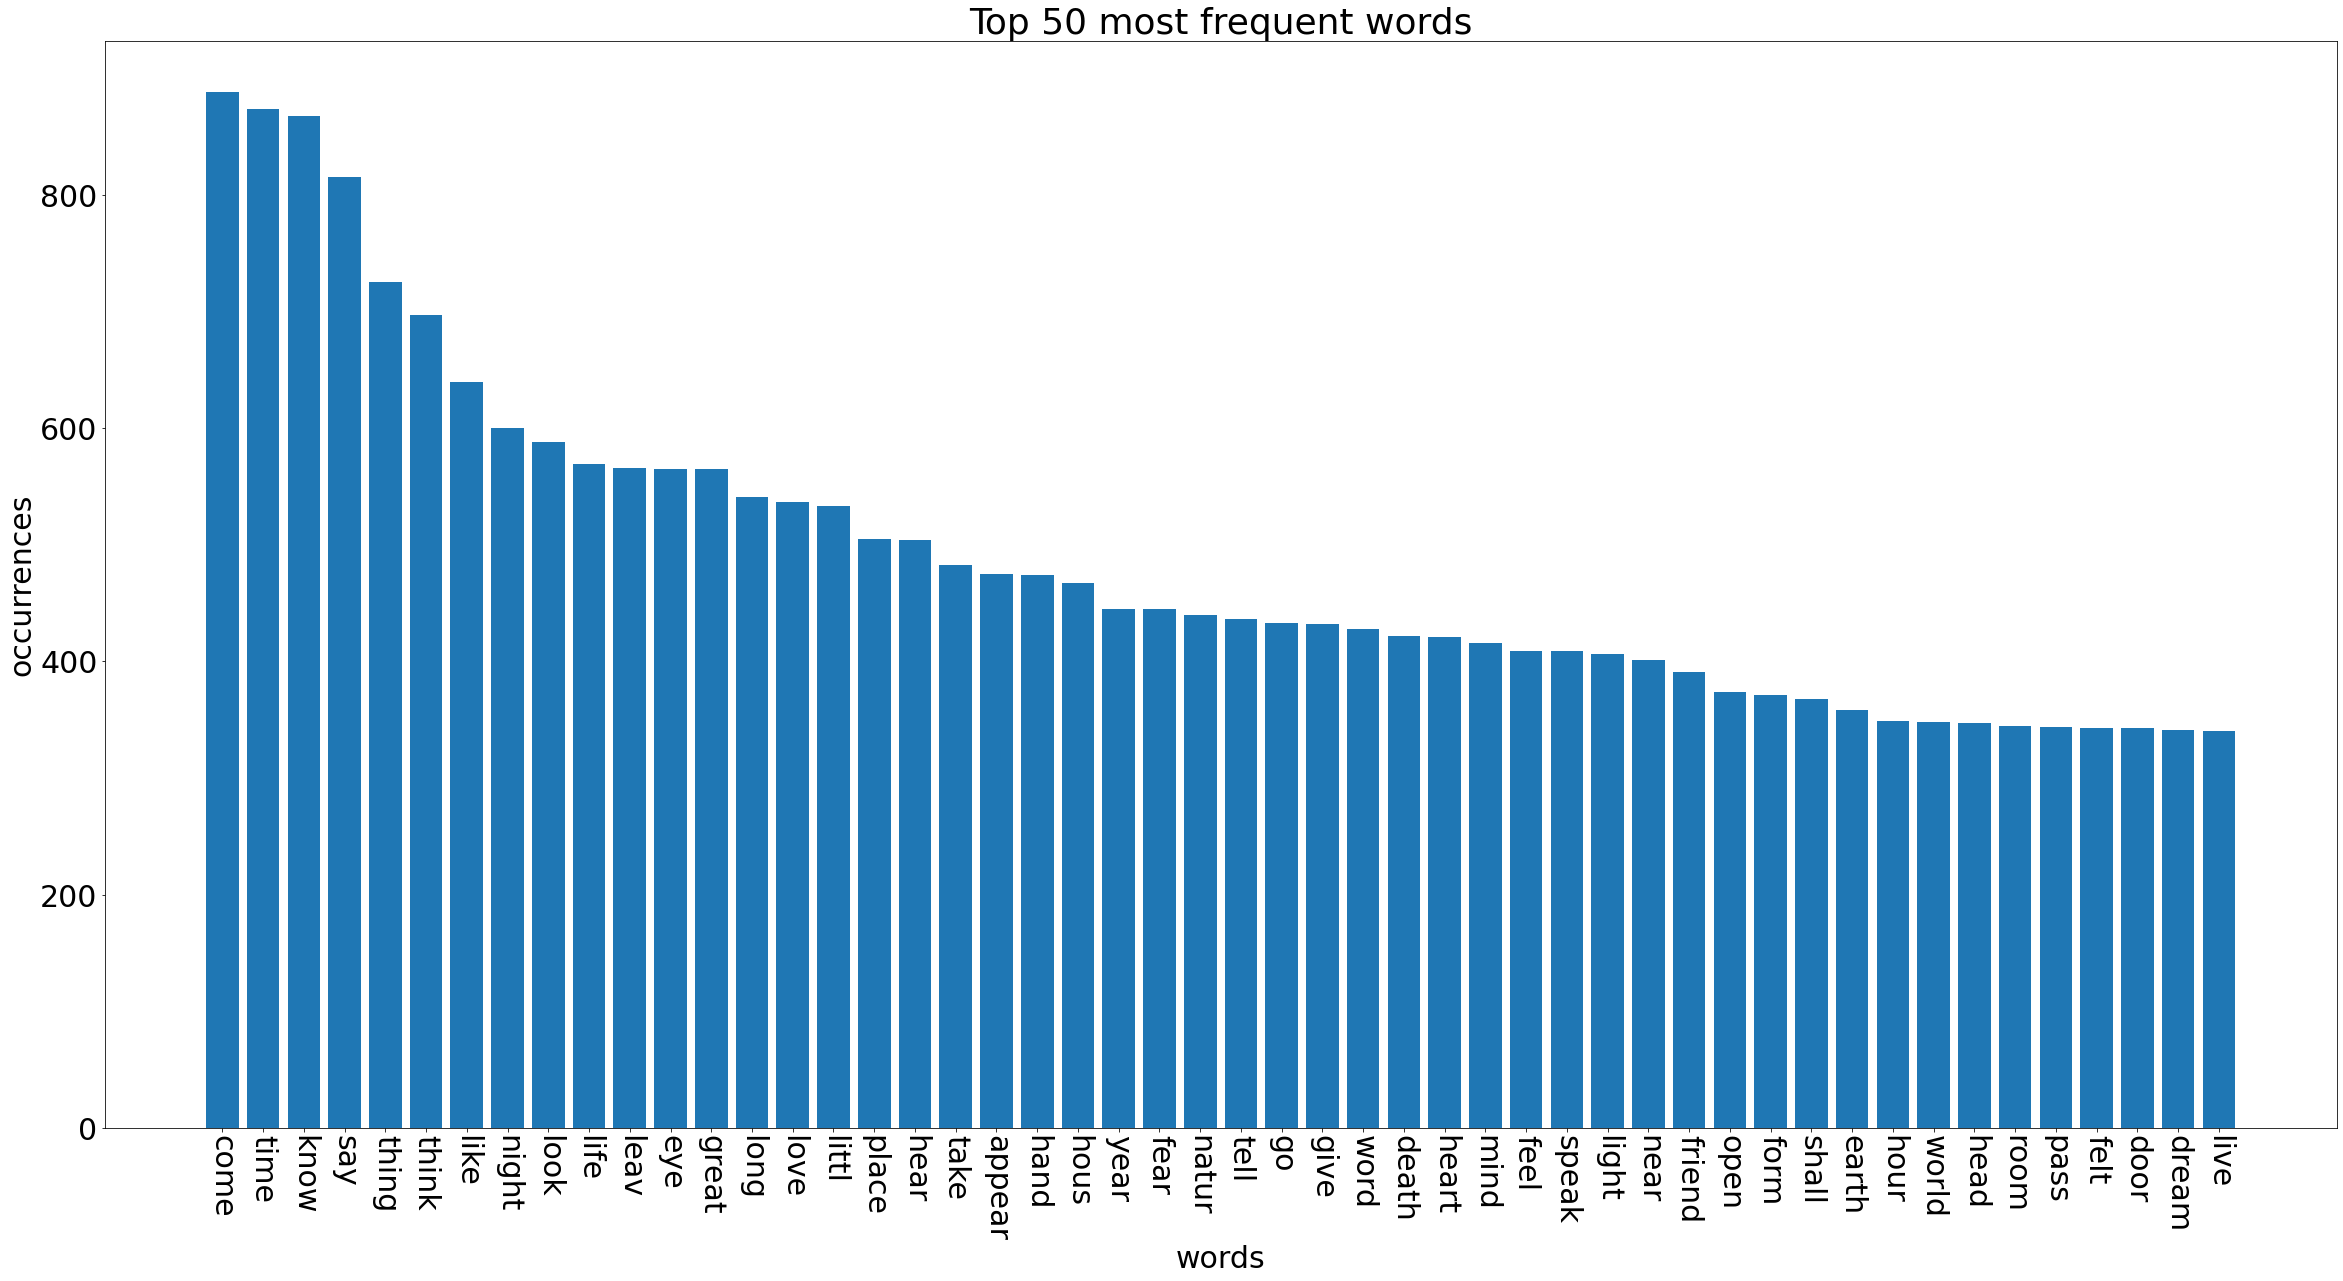

In [8]:
plot_frequent_words(texts, 50)

#### NMF

Implement topic modeling with NMF (you can use `sklearn.decomposition.NMF`) and print out resulting topics. Try to change hyperparameters to better fit the dataset.

In [9]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [10]:
nmf = NMF(n_components=10, random_state=0, beta_loss="kullback-leibler", solver="mu")
nmf.fit(tfidf_features)

/home/ubu/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(beta_loss='kullback-leibler', n_components=10, random_state=0, solver='mu')

In [11]:
def plot_topics_top_words(topics, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(topics):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

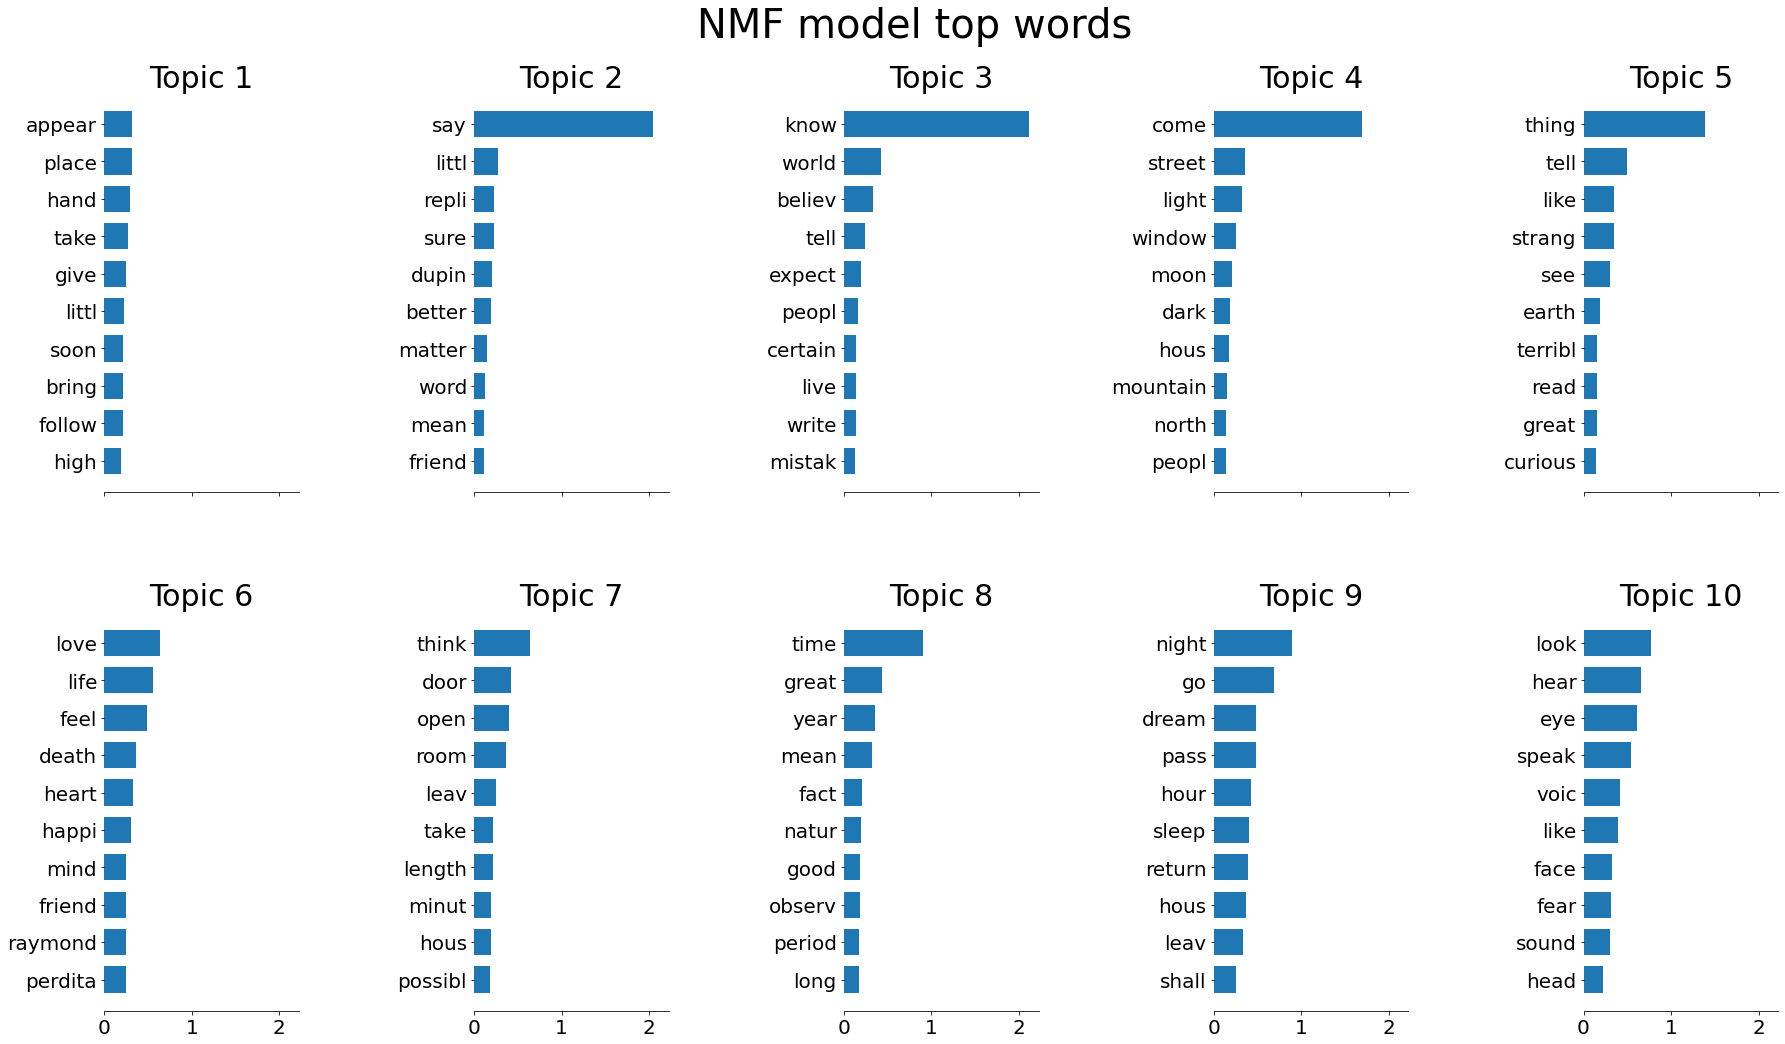

In [12]:
plot_topics_top_words(nmf.components_, tfidf_feature_names, 10, 'NMF model top words')

#### LDA

Implement topic modeling with LDA (you can use gensim implementation) and print out resulting topics. Try to change hyperparameters to better fit the dataset.

In [13]:
tf_vectorizer = CountVectorizer()
tf_features = tf_vectorizer.fit_transform(texts)
tf_feature_names = tf_vectorizer.get_feature_names_out()

In [14]:
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(tf_features)

LatentDirichletAllocation(random_state=0)

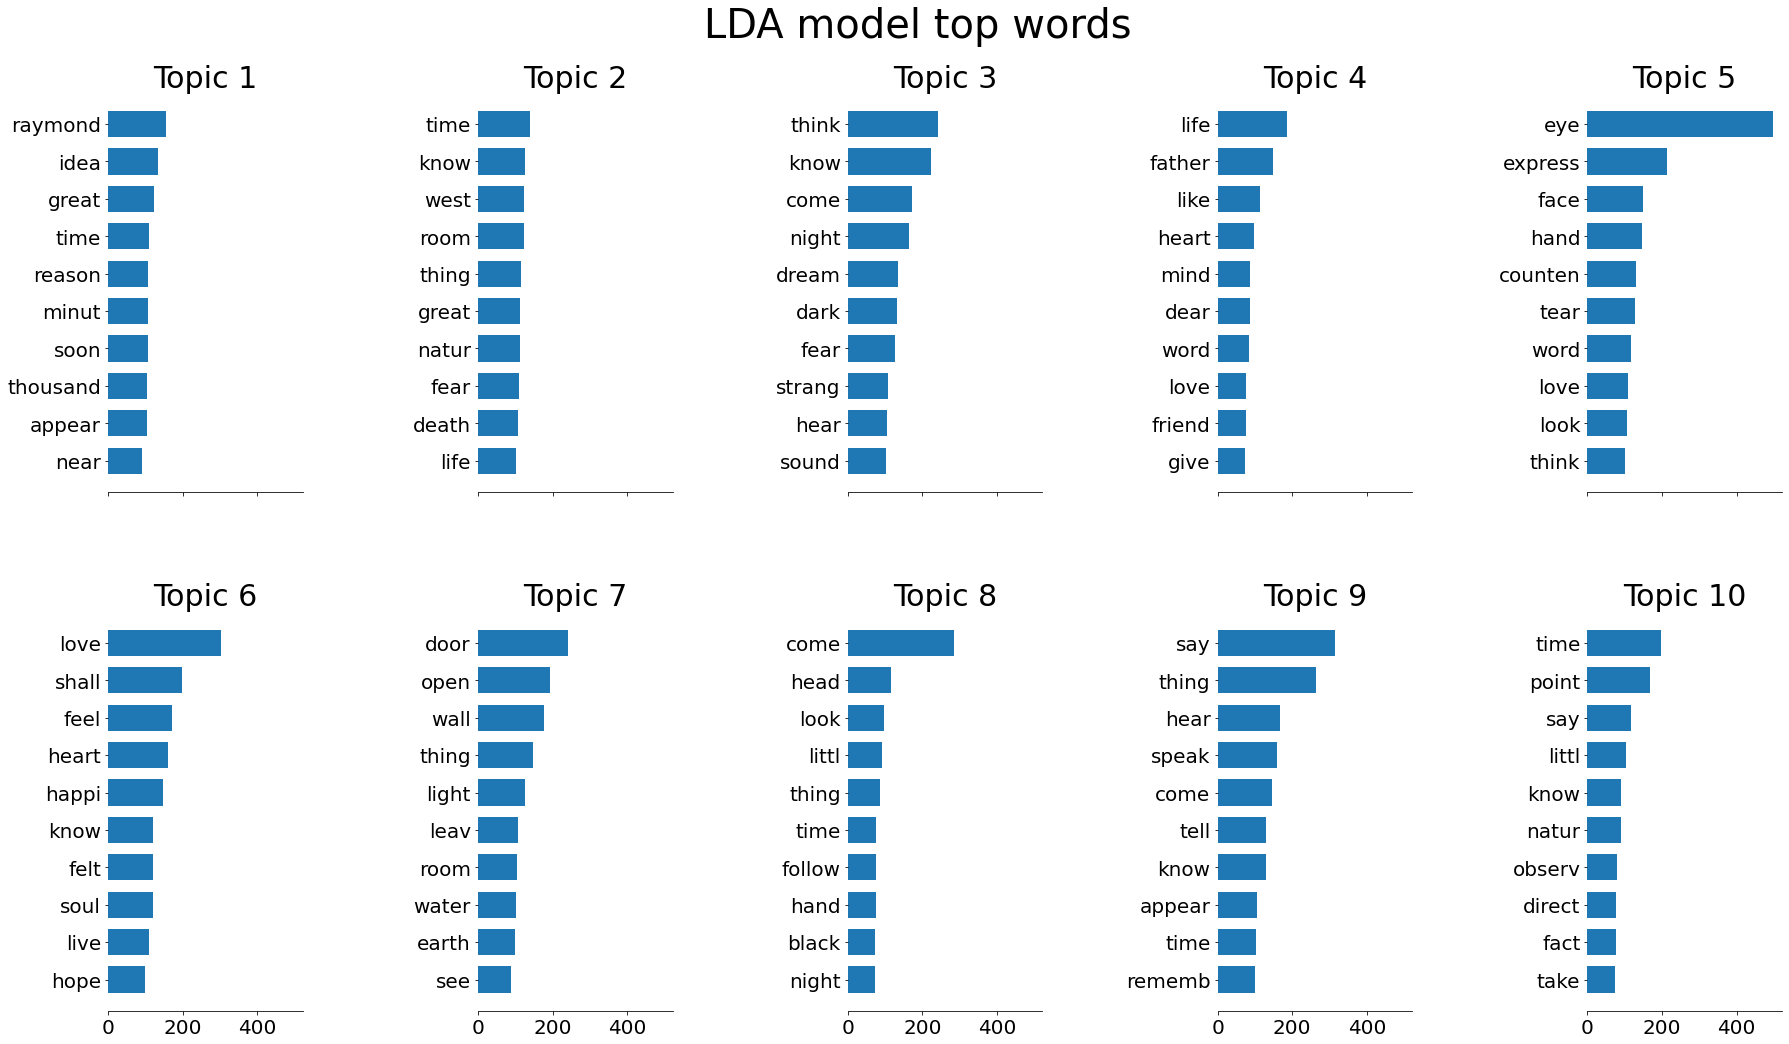

In [15]:
plot_topics_top_words(lda.components_, tf_feature_names, 10, 'LDA model top words')

### Additive regularization of topic models 

Implement topic modeling with ARTM. You may use bigartm library (simple installation for linux: pip install bigartm) or TopicNet framework (`https://github.com/machine-intelligence-laboratory/TopicNet`)

Create artm topic model fit it to the data. Try to change hyperparameters (number of specific and background topics) to better fit the dataset. Play with smoothing and sparsing coefficients (use grid), try to add decorrelator. Print out resulting topics.

In [16]:
import artm

In [17]:
num_topics = 10

In [18]:
batch_vectorizer = artm.BatchVectorizer(data_path='.', data_format='bow_uci',\
                                        collection_name='bow', target_folder='bow_batches')

In [19]:
dictionary = batch_vectorizer.dictionary

In [20]:
model_artm = artm.ARTM(num_topics=num_topics, topic_names=[f"topic_{i}" for i in range(num_topics)],\
                       cache_theta=True,\
                       scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary),\
                              artm.TopTokensScore(name='TopTokensScore', num_tokens=10)],\
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15)])

model_artm.initialize(dictionary)

In [21]:
model_artm.num_document_passes = 1

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

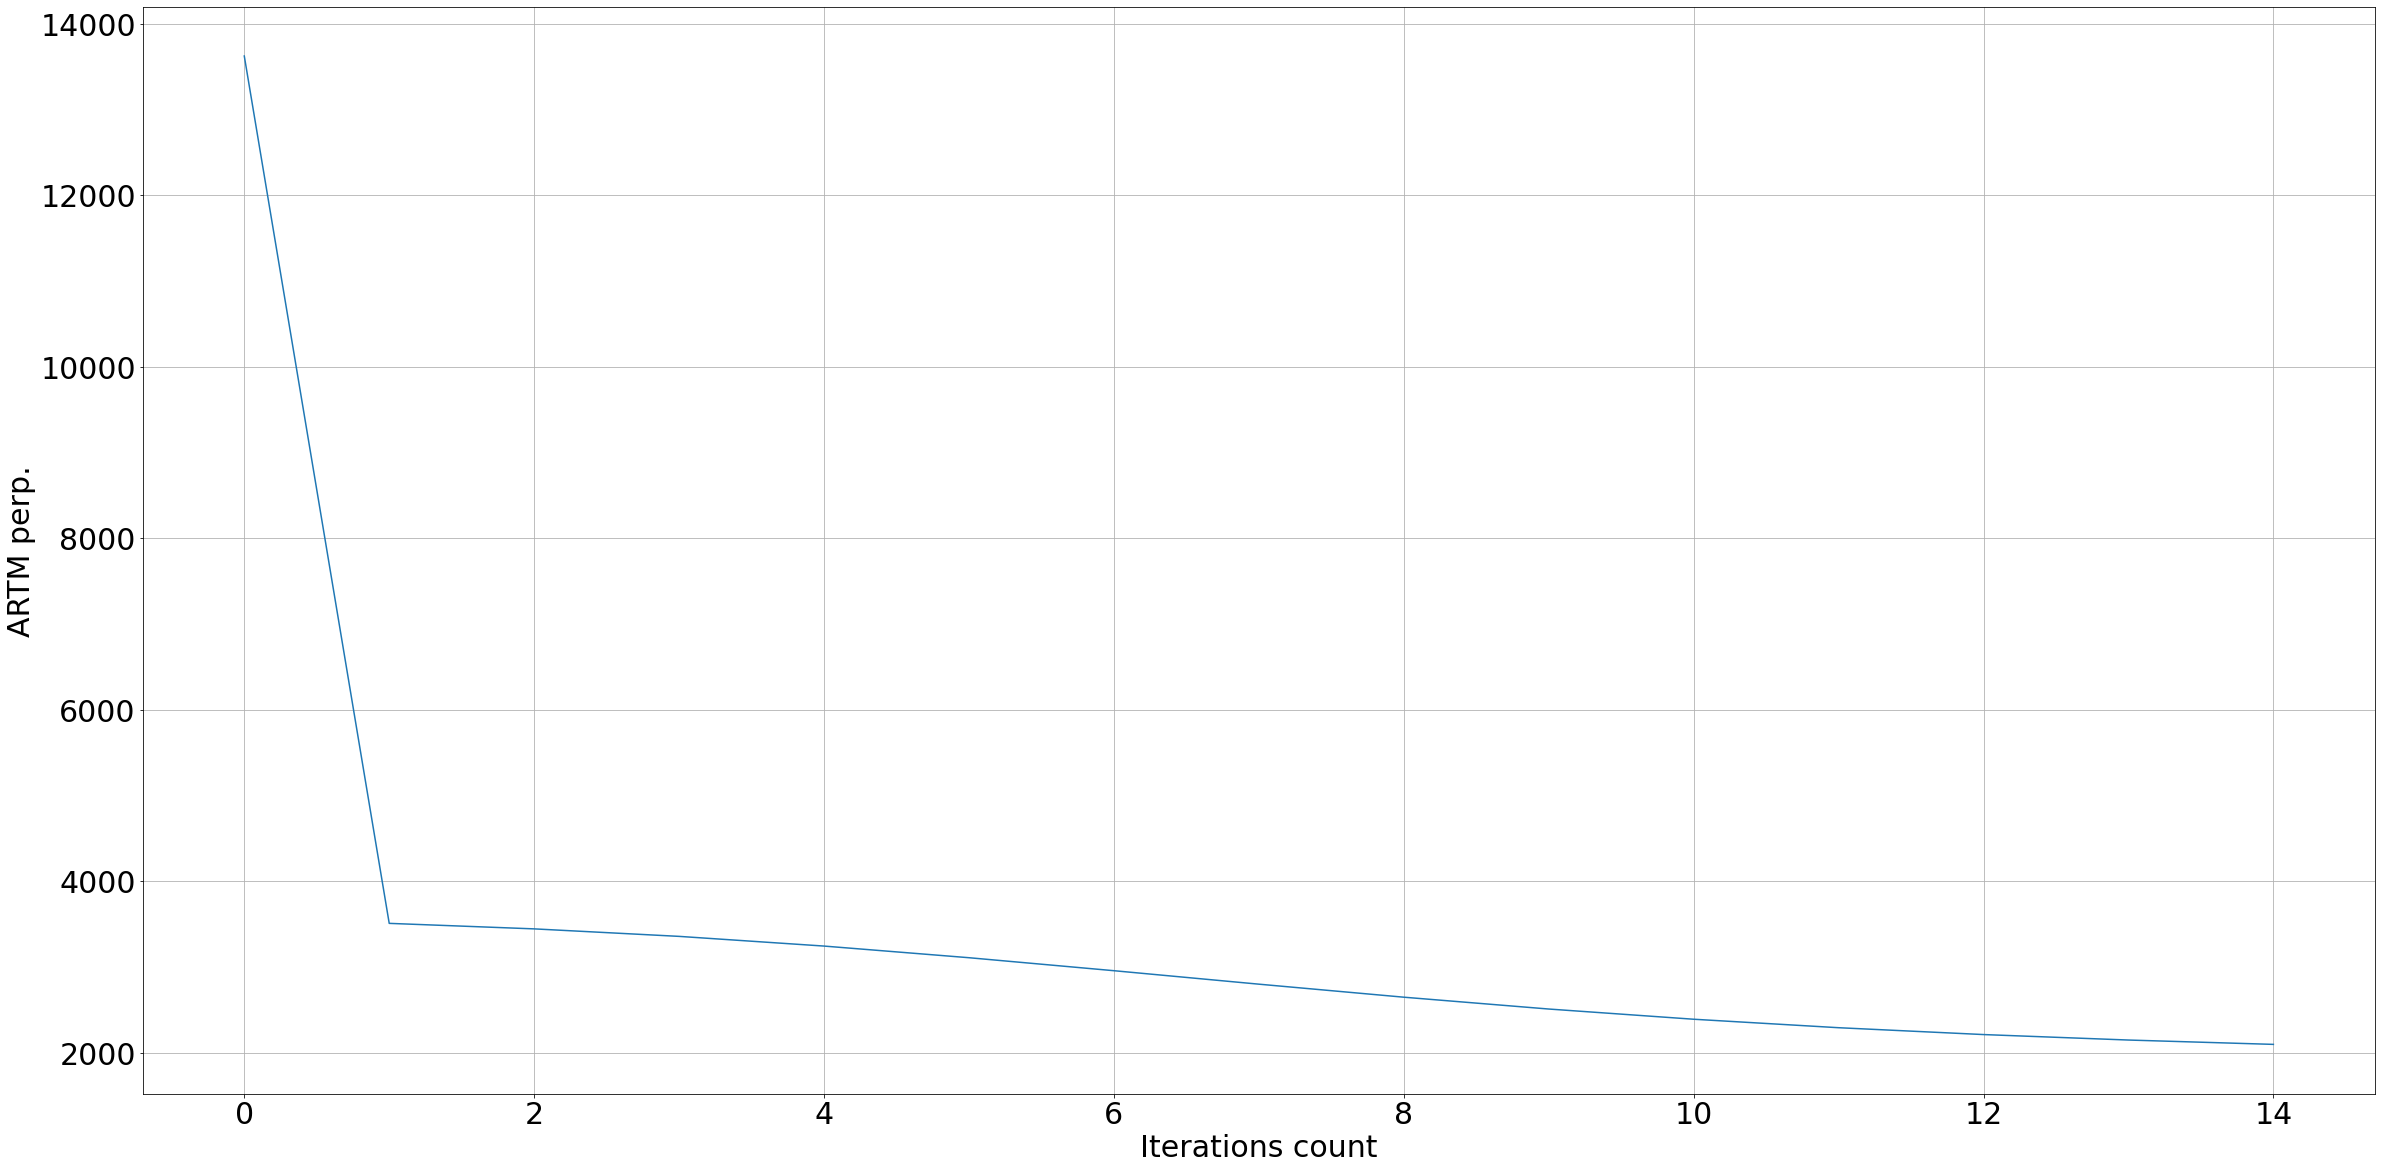

In [22]:
plt.plot(range(model_artm.num_phi_updates),\
         model_artm.score_tracker['PerplexityScore'].value)
plt.xlabel('Iterations count')
plt.ylabel('ARTM perp.')
plt.grid(True)
plt.show()

In [23]:
tf_feature_names_reverse = {w: i for i, w in enumerate(tf_feature_names)}

In [24]:
artm_tf_feature_names = model_artm.phi_.index.values
artm_tf_features = tf_features[:, [tf_feature_names_reverse[w] for w in artm_tf_feature_names]]

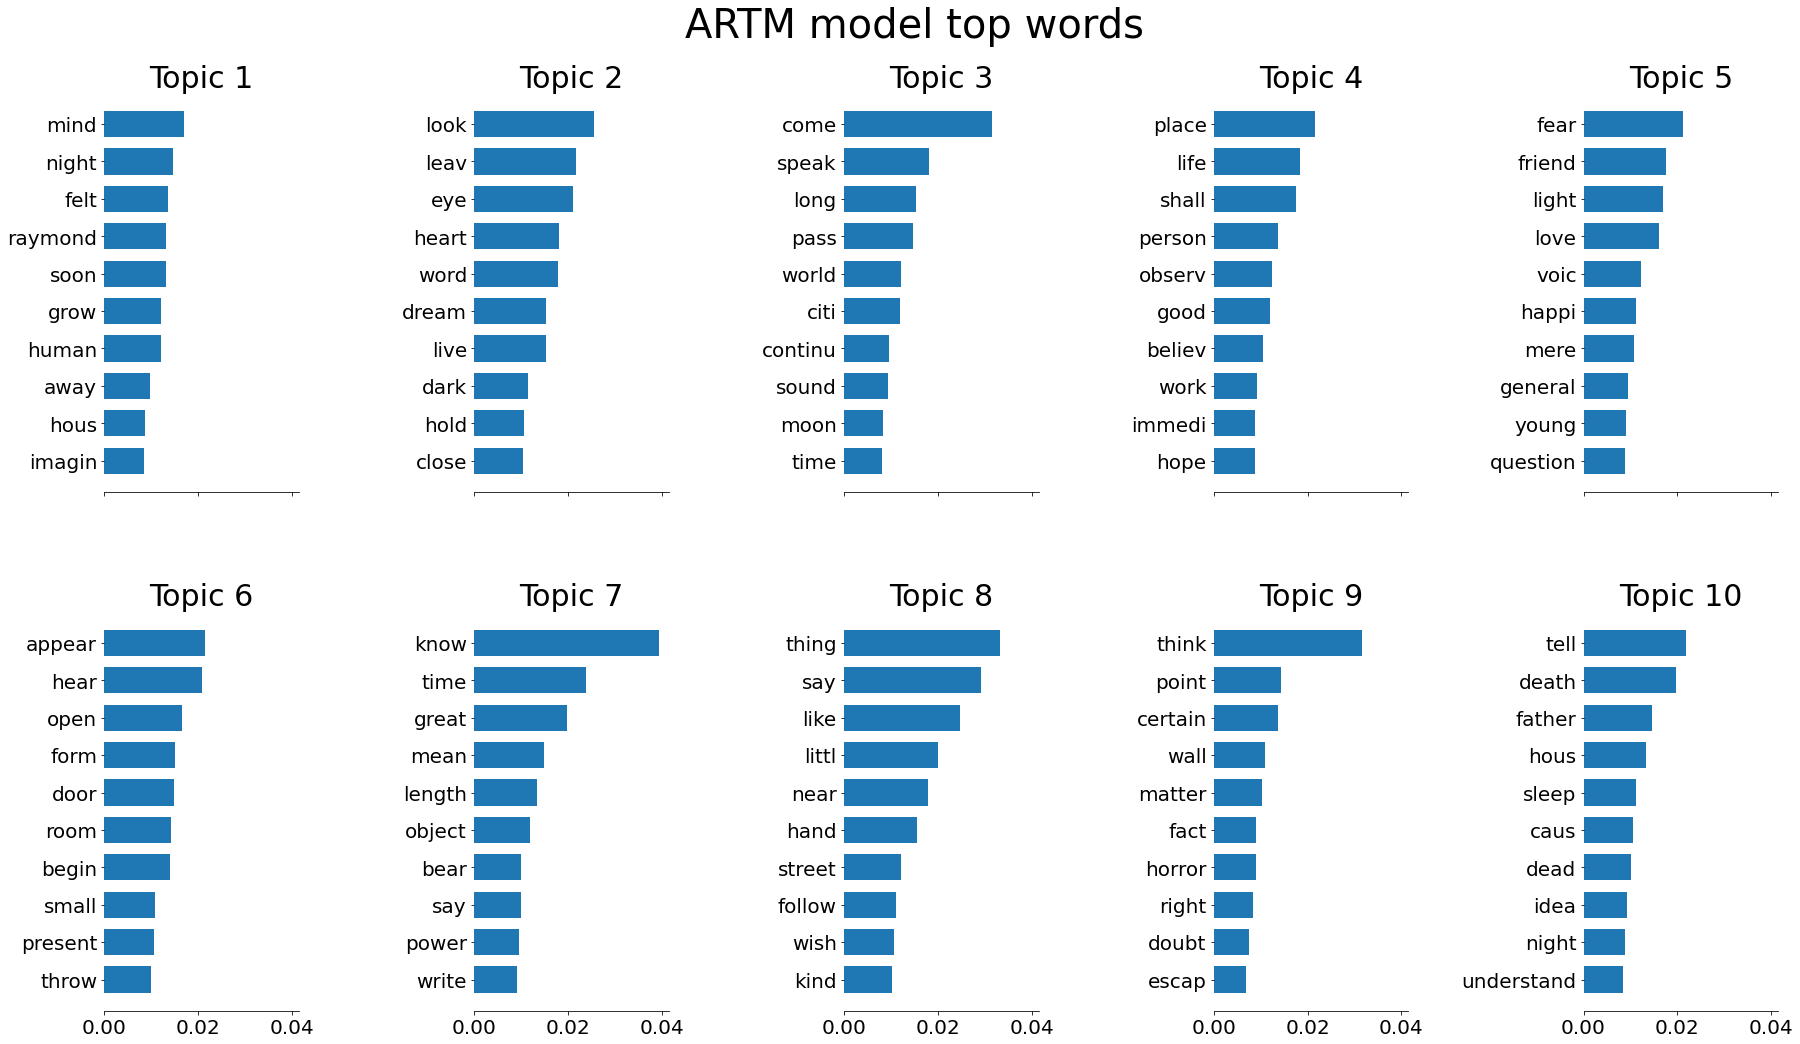

In [25]:
plot_topics_top_words(model_artm.phi_.values.T, artm_tf_feature_names, 10, 'ARTM model top words')

Quality scores for each model

In [26]:
results = []

results.append(['nmf', coherence_score(nmf.components_, tf_features),\
                    NPMI(nmf.components_, tf_features),\
                    based_on_distributed_representation(nmf.components_, tfidf_feature_names)])

results.append(['lda', coherence_score(lda.components_, tf_features),\
                    NPMI(lda.components_, tf_features),\
                    based_on_distributed_representation(lda.components_, tf_feature_names)])
    
results.append(['artm', coherence_score(model_artm.phi_.values.T, artm_tf_features),\
                    NPMI(model_artm.phi_.values.T, artm_tf_features),\
                    based_on_distributed_representation(model_artm.phi_.values.T, artm_tf_feature_names)])

results = pd.DataFrame(results, columns=['model', 'coherence score', 'npmi score', 'based on distributed representations score'])
results

,model,coherence score,npmi score,based on distributed representations score
0,nmf,-1.790284,0.039877,31.808676
1,lda,-1.697379,0.034212,31.597516
2,artm,-1.943072,0.017110,31.716784


In [27]:
def plot_bar(x, y, title, ylabel, ylim):
    ax = plt.subplot()
    ax.bar(x, y)
    ax.set_title(title)
    ax.set_xlabel('model')
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)
    return ax

<AxesSubplot:title={'center':'Coherence score of models'}, xlabel='model', ylabel='coherence score'>

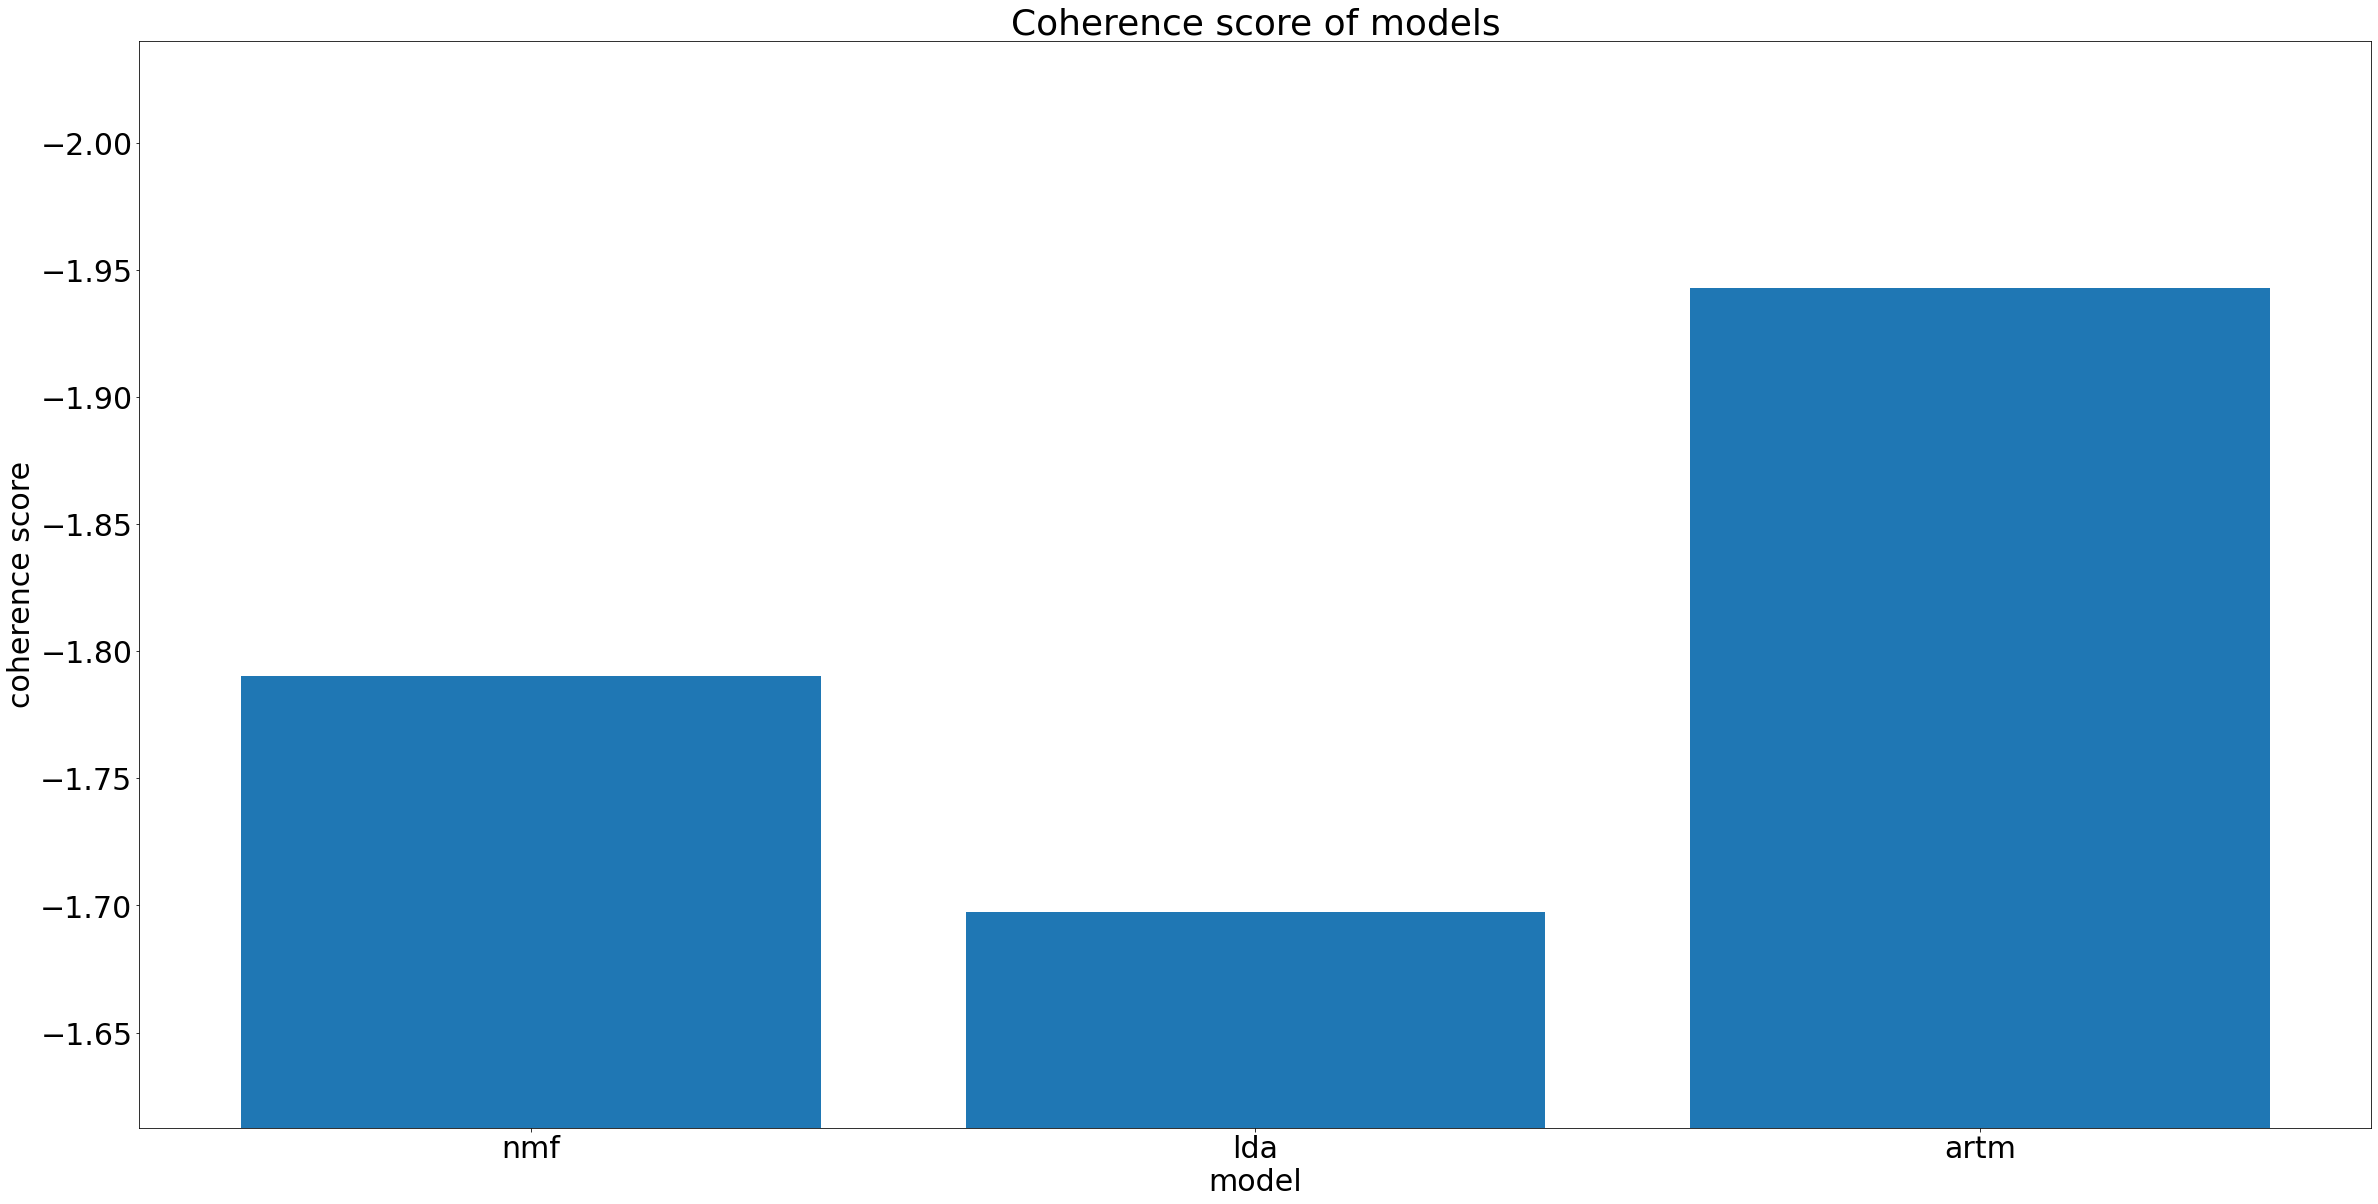

In [28]:
plot_bar(results['model'], results['coherence score'], title='Coherence score of models', ylabel='coherence score',\
        ylim=[max(results['coherence score']) * 0.95, min(results['coherence score']) * 1.05])

<AxesSubplot:title={'center':'NPMI score of models'}, xlabel='model', ylabel='npmi score'>

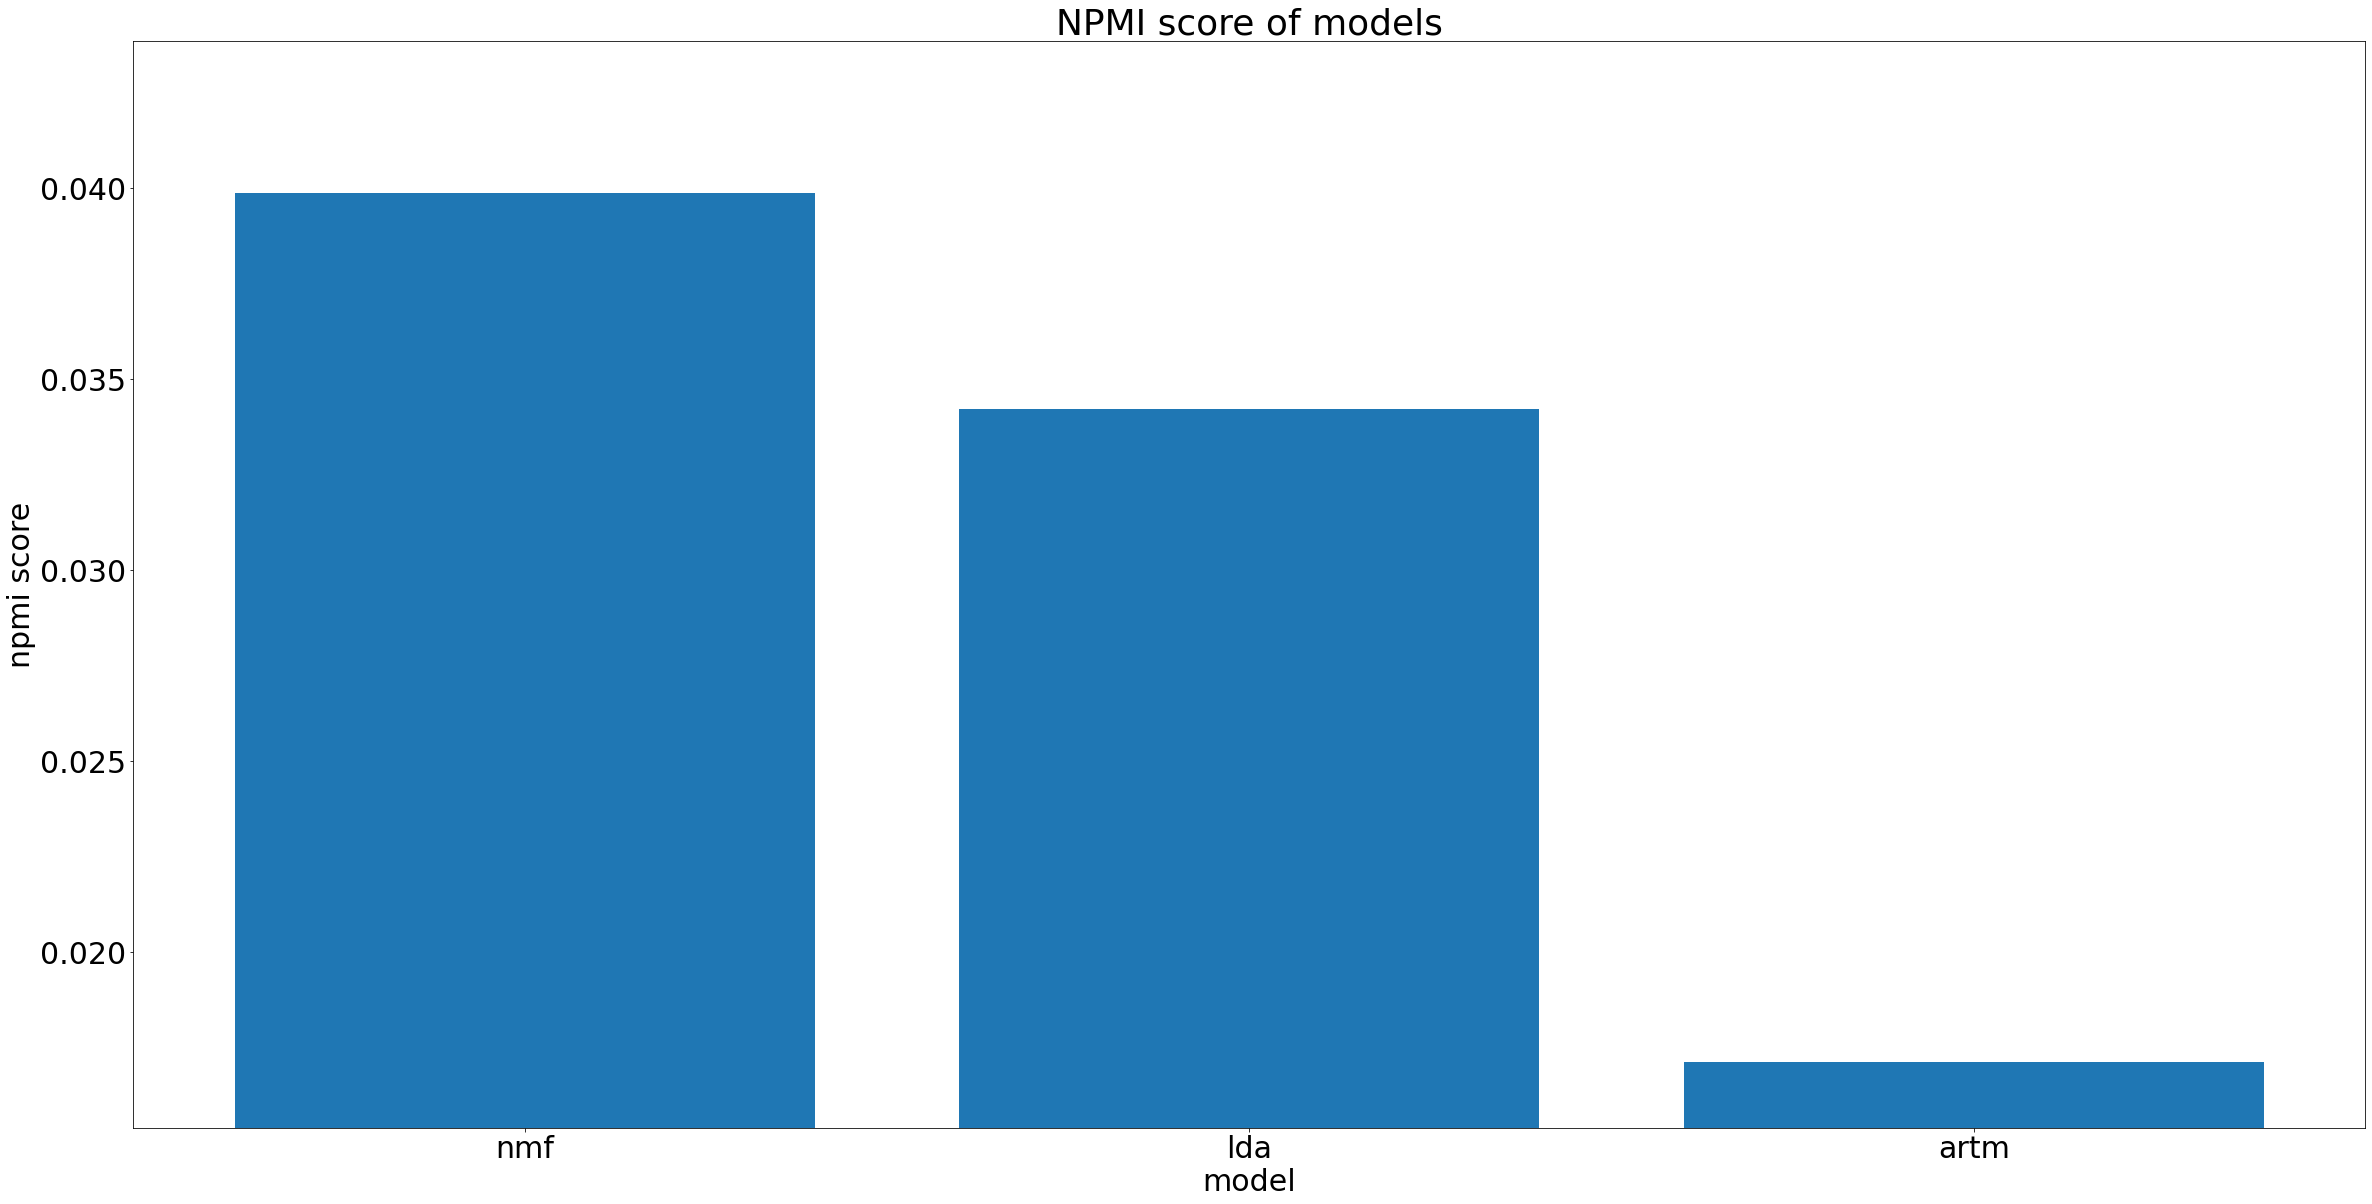

In [29]:
plot_bar(results['model'], results['npmi score'], title='NPMI score of models', ylabel='npmi score',\
        ylim=[min(results['npmi score']) * 0.9, max(results['npmi score']) * 1.1])

<AxesSubplot:title={'center':'Based on distributed representations score of models'}, xlabel='model', ylabel='based on distributed representations score'>

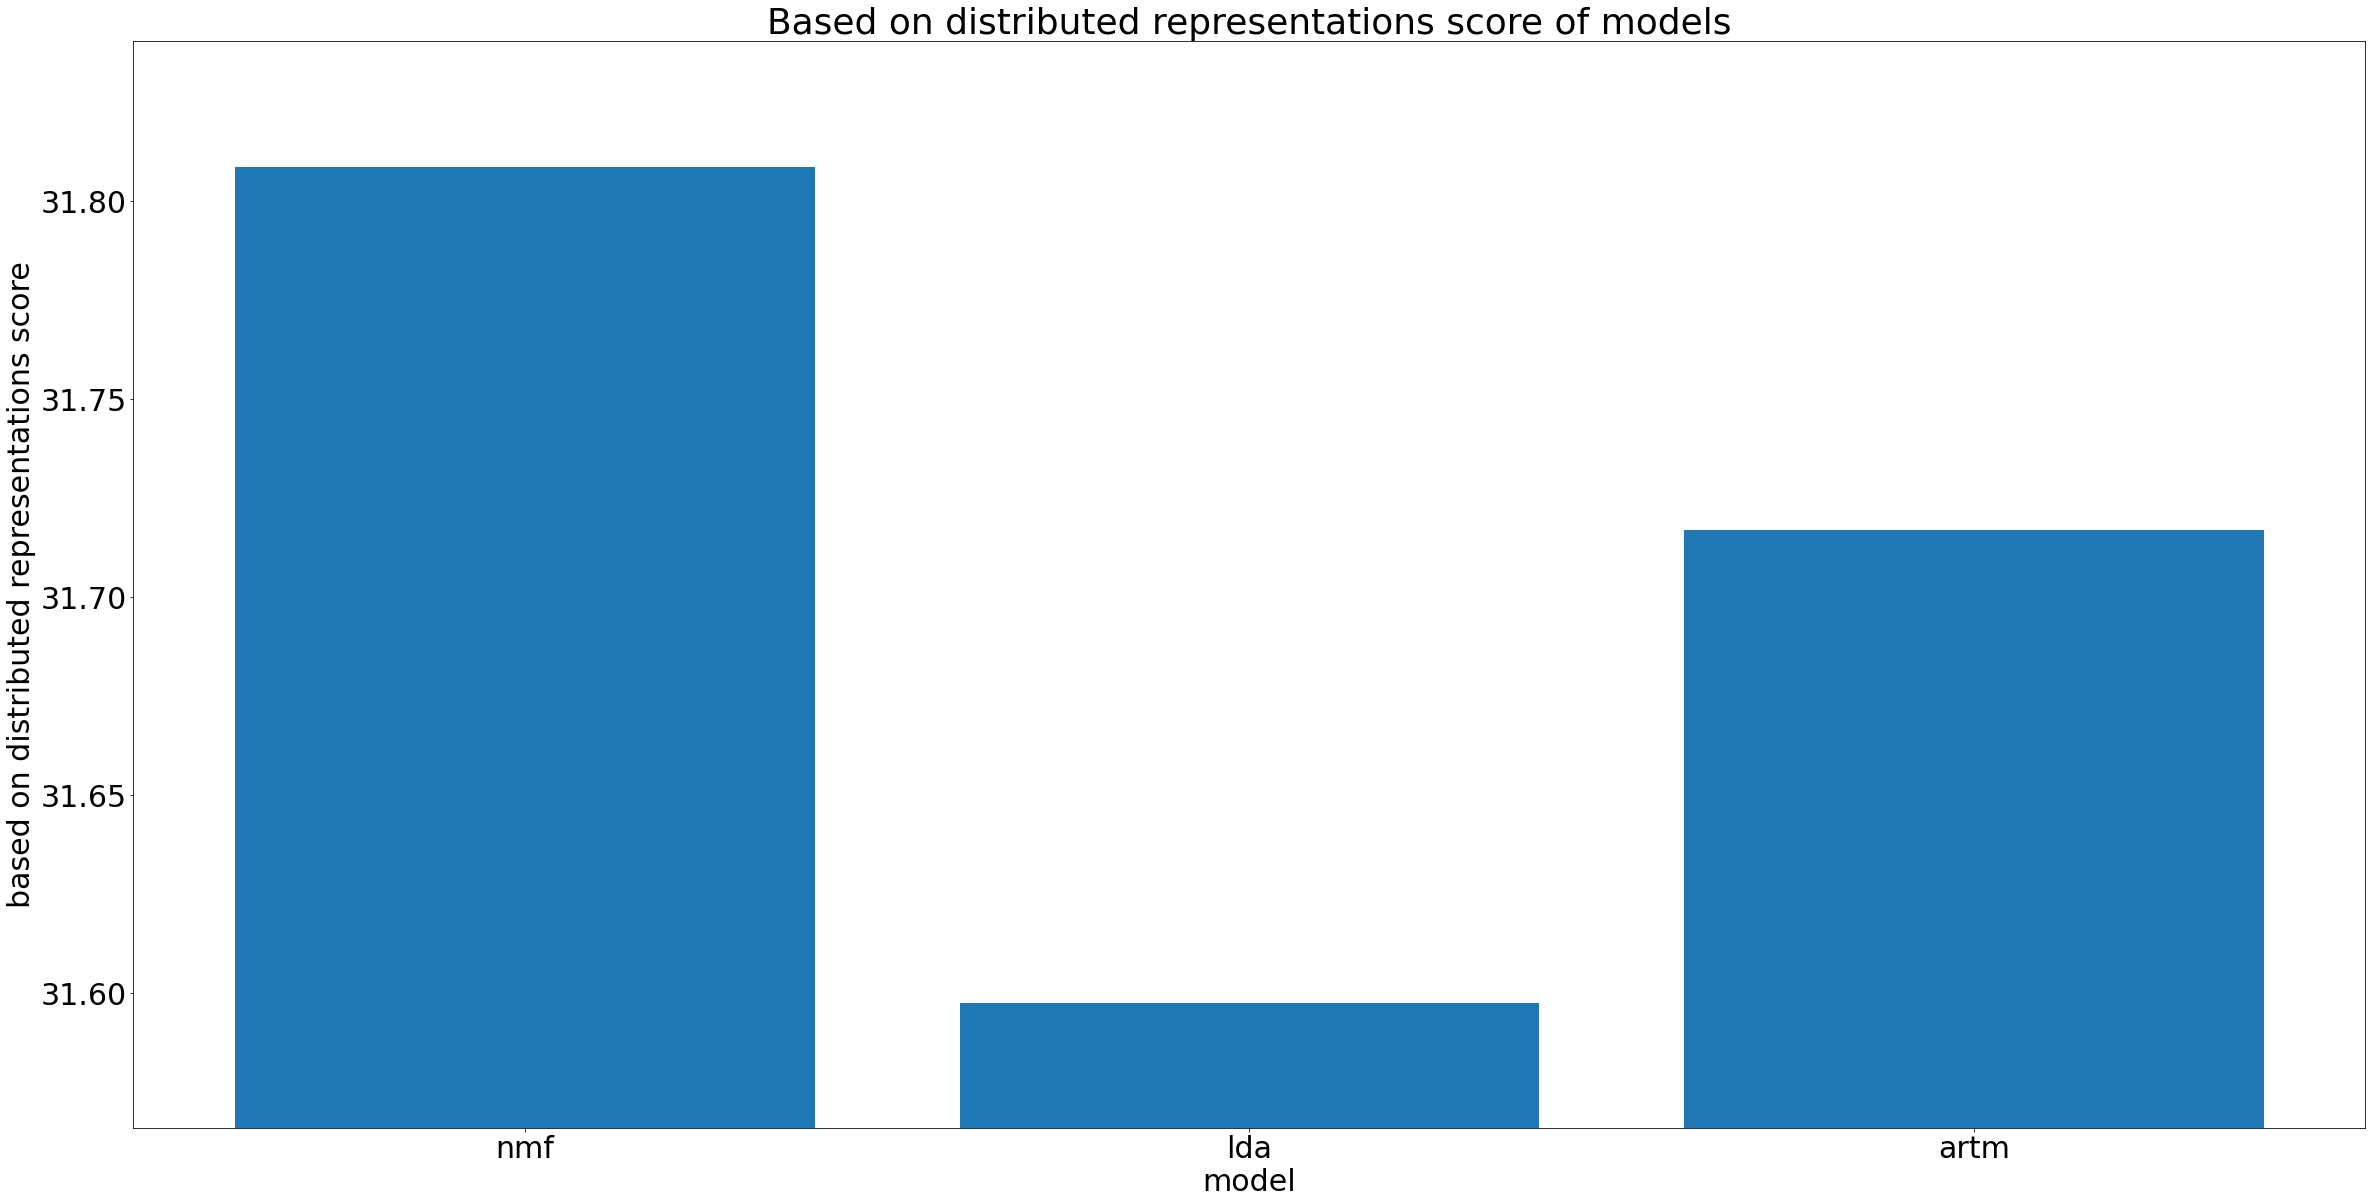

In [30]:
plot_bar(results['model'], results['based on distributed representations score'],\
         title='Based on distributed representations score of models',\
         ylabel='based on distributed representations score',\
        ylim=[min(results['based on distributed representations score']) * 0.999,\
              max(results['based on distributed representations score']) * 1.001])

Write a function to convert new documents to topics probabilities vectors.

In [31]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import logging


class BagOfWordsModel(object):
    OUT_FOLDER = 'out'

    def __init__(self, id_document_dict, max_features=None, max_df=1.0):
        """Builds bow model.

        Args:
            id_document_dict: ids of documents and theirs contents in format
                "{id: 'text', ...}"
            max_features: If not None, build a vocabulary that only consider the top
                max_features ordered by term frequency across the corpus.
                This parameter is ignored if vocabulary is not None.
            max_df: When building the vocabulary ignore terms that have a
                document frequency strictly higher than the given threshold
                (corpus-specific stop words). If float, the parameter
                represents a proportion of documents, integer absolute counts.
                This parameter is ignored if vocabulary is not None.
        """
        self.logger = logging.getLogger(__name__)
        self.logger.info(
            "Building bag-of-words model with max_features={0}, max_df={1}".format(
                max_features, max_df))
        self.logger.info("Size of data set: " + str(len(id_document_dict)))

        if len(id_document_dict) != 0:
            self.logger.info("Building pandas dataframe")
            df = pd.DataFrame.from_dict(data=id_document_dict, orient='index')
            self.logger.info("Built pandas dataframe")
            ids = df.index
            self.index2id = dict(enumerate(ids))
            self.id2index = {v: k for k, v in self.index2id.items()}
            documents_corpus = df[0].values  # 1-dim np.array.
            # documents_corpus = documents_corpus.astype(unicode)
            del df
            if max_features is None:
                self.logger.info(
                    "Training CountVectorizer with all {0} features".format(
                        len(ids)))
            else:
                self.logger.info(
                    "Training CountVectorizer with max {0} features".format(
                        max_features))
            vectorizer = CountVectorizer(max_features=max_features,
                                         max_df=max_df,
                                         stop_words='english').fit(
                documents_corpus)
            self.logger.info("Trained vectorizer with {0} features".format(
                len(vectorizer.get_feature_names())))
            self.logger.info("Building bag-of-words model")
            bow = vectorizer.transform(documents_corpus)
            self.logger.info("Done")

            self.url_ids = ids
            self.bow_sparse_matrix = bow
            self.feature_names = vectorizer.get_feature_names()  # mapping from url_id to url
            self.vocabulary = vectorizer.vocabulary_  # mapping from url to url_id
            self.shape = self.bow_sparse_matrix.shape

    def get_index(self, doc_id):
        return self.id2index[doc_id]

    def get_doc_id(self, index):
        return self.index2id[index]

    def get_feature_id(self, feature_name):
        return self.vocabulary.get(feature_name)

    def get_feature_name(self, feature_id):
        return self.feature_names[feature_id]

    def toarray(self):
        return self.bow_sparse_matrix.toarray()

    def to_uci(self, model_name='bow', save_folder=OUT_FOLDER):
        import os.path
        import codecs
        if self.bow_sparse_matrix is None:
            self.logger.error("Model is None.")
            return
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        filenames = model_name
        docword_name = os.path.join(save_folder,
                                    'docword.' + filenames + '.txt')
        vocab_name = os.path.join(save_folder, 'vocab.' + filenames + '.txt')
        with codecs.open(docword_name, 'w', encoding='utf-8') as docword_f, \
                codecs.open(vocab_name, 'w', encoding='utf-8') as vocab_f:
            urls_count = self.shape[0]
            words_count = self.shape[1]
            # Fill vocab_f file
            self.logger.info("Start filling {0}".format(vocab_name))
            for i in range(words_count):
                vocab_f.write(self.get_feature_name(i) + '\n')
            self.logger.info("Done.")
            # Fill docword_f file
            self.logger.info("Start filling {0}".format(docword_name))
            docword_f.write(str(urls_count) + '\n')
            docword_f.write(str(words_count) + '\n')
            docword_f.write(str(self.bow_sparse_matrix.nnz) + '\n')
            # nnz_position = docword_f.tell() # We fill this line later with nnz_counter.
            # nnz_counter = 0 # The number of nonzero counts in the bag-of-words.
            nnz_x, nnz_y = self.bow_sparse_matrix.nonzero()
            for x, y in zip(nnz_x, nnz_y):
                # nnz_counter += len(url_sparse_vector)
                docword_f.write(str(x + 1) + ' ' + str(y + 1) + ' ' + str(
                    self.bow_sparse_matrix[x, y]) + '\n')
            self.logger.info("Done.")

In [32]:
def nmf_predict(texts):
    feats = tfidf_vectorizer.transform([' '.join(preprocess(text)) for text in texts])
    results = nmf.transform(feats)
    results = np.apply_along_axis(lambda arr: arr / arr.sum(), 1, results)  # to probabilities
    return results

def lda_predict(texts):
    feats = tf_vectorizer.transform([' '.join(preprocess(text)) for text in texts])
    results = lda.transform(feats)
    return results

def artm_predict(texts):
    bow_model = BagOfWordsModel({i: ' '.join(preprocess(text)) for i, text in enumerate(texts)})
    bow_model.to_uci('temp', '.')
    
    batch_vectorizer_temp = artm.BatchVectorizer(data_path='.', data_format='bow_uci',\
                                        collection_name='temp', target_folder='temp_batches')
    
    results = model_artm.transform(batch_vectorizer_temp)
    return results

In [33]:
for model_name, predict in (('nmf', nmf_predict), ('lda', lda_predict), ('artm', artm_predict)):
    print(model_name)
    print(predict(data.text[0:1]), '\n')

nmf
[[1.41499710e-01 2.11454620e-16 2.86259887e-01 3.13821815e-12
  8.98897580e-20 1.29426949e-24 8.97974685e-02 4.71782081e-01
  1.06608527e-02 0.00000000e+00]] 

lda
[[0.10706434 0.29520277 0.00666793 0.00666929 0.00666854 0.00666905
  0.24356926 0.00666843 0.006668   0.31415239]] 

artm
                1
topic_0  0.028004
topic_1  0.000000
topic_2  0.145288
topic_3  0.041660
topic_4  0.167404
topic_5  0.015482
topic_6  0.077025
topic_7  0.000000
topic_8  0.355436
topic_9  0.169701 



/home/ubu/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
